# STG single neuron

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine

In [3]:
from neuroprobnum.utils import stim_utils, math_utils
from neuroprobnum.utils import plot_utils as pltu

# Stimulus

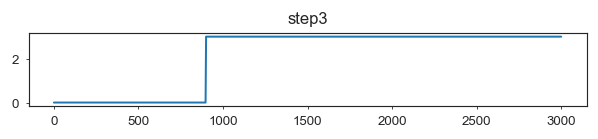

In [4]:
t0, tmax = 0, 3000
Iamp = 3
stim = stim_utils.IStimStep(Iamp=Iamp, onset=900, offset=tmax*2, name=f'step{Iamp}')
stim.plot(t0=t0, tmax=tmax)

# Generator

In [5]:
from neuroprobnum.models.stg_model import get_stg_model

panel = 'b'
neuron = get_stg_model(n_neurons=1, g_params=panel, stim=stim)
neuron

STG_model(n_neurons=1)

In [6]:
from neuroprobnum.generator.generator_stg import DataGeneratorSTG

gen = DataGeneratorSTG(
    y0=neuron.y0, t0=t0, tmax=tmax, t_eval_adaptive=math_utils.t_arange(t0, tmax, 1),
    n_samples=100, n_parallel=20, model=neuron, yidxs=np.arange(13),
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
    base_folder='data/singleSTGneuron'
)
gen.update_subfoldername(stim=stim.name, panel=panel)

## Test

  0%|          | 0/20 samples [00:00<?]

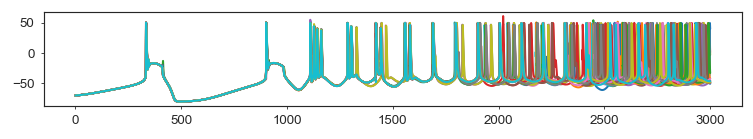

CPU times: user 1.19 s, sys: 2.72 s, total: 3.92 s
Wall time: 2.96 s


In [7]:
%%time
solver = gen.get_solver(method='EE', step_param=0.1, pert_method='conrad', adaptive=0)
sol = solver.solve(tmax=tmax, n_samples=20)
sol.plot(y_idxs=[0])

# Data

## Generate data

In [8]:
pert_method = 'abdulle_ln'
adaptive = 0
method = 'EE'
step_param = 0.1

gen.gen_and_save_data(
    stim=stim, method=method, adaptive=adaptive, step_param=step_param,
    pert_method=pert_method, overwrite=False, plot=True
);

    stim_step3_panel_b_tmax_3000/EE_f(0.1)_abdulle_ln(1).pkl --> Data already exists.


## Load data

In [9]:
from neuroprobnum.generator.dataloader import DataLoader

df = DataLoader(gen).load_data2dataframe([(pert_method, adaptive, [method], [step_param])], allowgenerror=False, MAEs=False)
df.columns

Index(['acc_ts', 'acc_vs', 'acc_ys', 'adaptive', 'det_nODEcalls',
       'det_run_time', 'det_ts', 'det_vs', 'det_ys', 'method', 'nODEcalls',
       'n_samples', 'pert_method', 'pert_param', 'run_times', 'seed',
       'step_param', 't0', 'tmax', 'ts', 'vs', 'ys'],
      dtype='object')

# Plot

## Plot example

In [10]:
yidxs = [0, 1]

In [11]:
example_data_row = df.iloc[0]
example_data_row

acc_ts           [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...
acc_vs           [-69.89590063441594, -69.89350531342023, -69.8...
acc_ys           [[-69.89590063441594, 0.07178884109620841, 0.0...
adaptive                                                         0
det_nODEcalls                                                30000
det_run_time                                              0.852139
det_ts           [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...
det_vs           [-69.89590063441594, -69.8935093393032, -69.89...
det_ys           [[-69.89590063441594, 0.07178884109620841, 0.0...
method                                                          EE
nODEcalls        [30000, 30000, 30000, 30000, 30000, 30000, 300...
n_samples                                                      100
pert_method                                             abdulle_ln
pert_param                                                       1
run_times        [1.3029429912567139, 1.3438529968261719, 1.45

In [12]:
from neuroprobnum.utils.figure_utils import plot_stim

def plot_ref_and_mean(ax, ts, ys, acc_ys):
    ax.plot(ts, acc_ys, c='k', lw=1, label='ref.')
    ax.plot(ts, np.mean(ys, axis=0), c='C0', alpha=0.8, lw=1, label='mean')
    
def compute_abs_error(y1, yref):
    return np.abs(y1 - yref)

def compute_rel_error(y1, yref):
    return np.abs(y1 - yref) / np.maximum(np.abs(y1), np.abs(yref))
    
def plot_abs_error(ax, ts, ys, acc_ys):
    abs_errors = np.zeros_like(ys)
    
    for i, yi in enumerate(ys):
        abs_errors[i, :] = compute_abs_error(yi, acc_ys)
    
    ax.plot(ts, np.mean(abs_errors, axis=0), c='darkred', lw=1, zorder=100, label='mean')
    ax.plot(ts, np.percentile(abs_errors, q=10, axis=0), color='red', alpha=0.5, lw=1, label='_')
    ax.plot(ts, np.percentile(abs_errors, q=90, axis=0), color='red', alpha=0.5, lw=1, label='q(10-90)')
    
def plot_rel_error(ax, ts, ys, acc_ys):
    rel_errors = np.zeros_like(ys)
    
    for i, yi in enumerate(ys):
        rel_errors[i, :] = compute_rel_error(yi, acc_ys)
    
    ax.plot(ts, np.mean(rel_errors, axis=0), c='darkred', lw=1, zorder=100, label='mean')
    ax.plot(ts, np.percentile(rel_errors, q=10, axis=0), color='red', alpha=0.5, lw=1, label='_')
    ax.plot(ts, np.percentile(rel_errors, q=90, axis=0), color='red', alpha=0.5, lw=1, label='q(10-90)')

In [13]:
stim_ts = np.linspace(0, tmax, 1001)

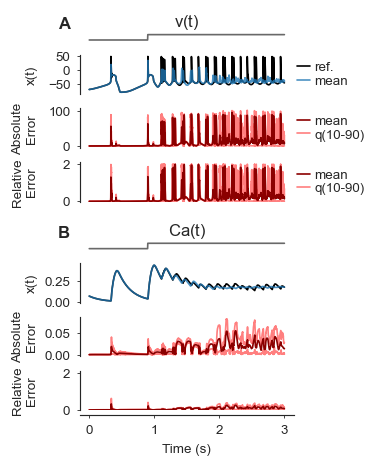

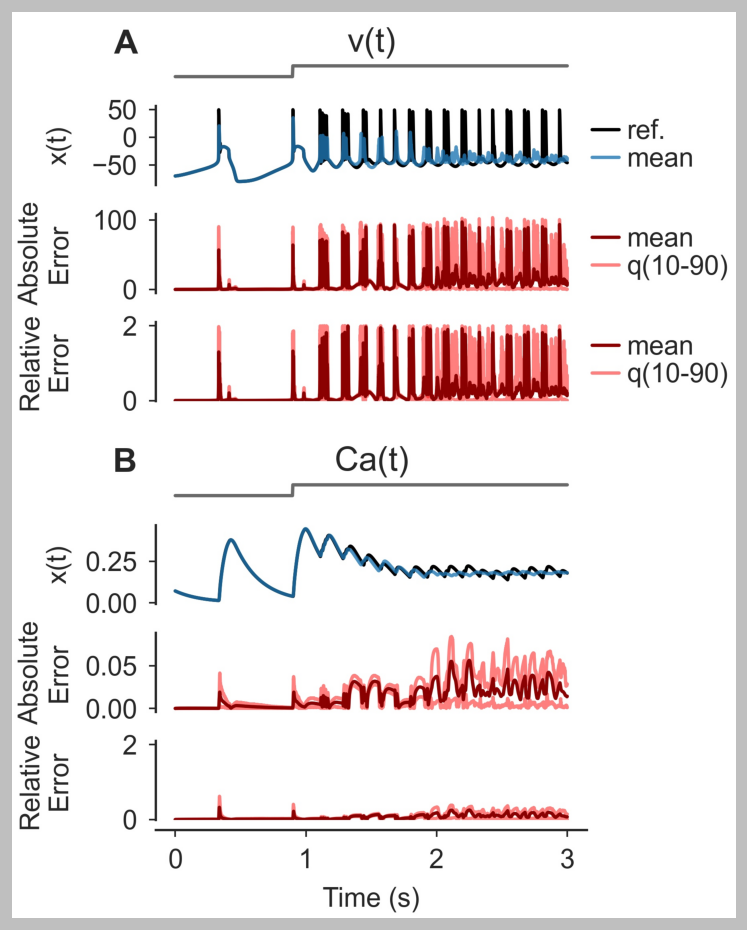

In [17]:
n_cols = 1
n_rows = 8

fig, axs = pltu.subplots(n_cols, n_rows, xsize='col', ysizerow=0.47, gridspec_kw=dict(height_ratios=(0.15, 1, 1, 1, 0.15, 1, 1, 1)))

despine()

for ax_set, yidx in zip([axs[:4], axs[4:]], yidxs):  
    plot_stim(ax=ax_set[0], ts=stim_ts, stim=[stim.get_I_at_t(t) for t in stim_ts])
    plot_ref_and_mean(ax=ax_set[1], ts=example_data_row.ts, ys=example_data_row.ys[:, :, yidx], acc_ys=example_data_row.acc_ys[:, yidx])
    plot_abs_error(ax=ax_set[2], ts=example_data_row.ts, ys=example_data_row.ys[:, :, yidx], acc_ys=example_data_row.acc_ys[:, yidx])
    plot_rel_error(ax=ax_set[3], ts=example_data_row.ts, ys=example_data_row.ys[:, :, yidx], acc_ys=example_data_row.acc_ys[:, yidx])
    

axs[1].legend(loc='center left', bbox_to_anchor=(1,0.5), handlelength=1)
axs[2].legend(loc='center left', bbox_to_anchor=(1,0.5), handlelength=1)
axs[3].legend(loc='center left', bbox_to_anchor=(1,0.5), handlelength=1)
    
for ax_set in [axs[:4], axs[4:]]:
    ax_set[1].set_ylabel("x(t)")
    ax_set[2].set_ylabel("Absolute\nError")
    ax_set[3].set_ylabel("Relative\nError")
    
fig.align_labels()

for ax in [axs[3], axs[7]]:
    ax.set_ylim(-0.01, None)
pltu.make_share_ylims([axs[3], axs[7]])
pltu.make_share_xlims(axs)

for ax in axs[:-1]:
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
pltu.move_xaxis_outward(axs[-1])
    
pltu.set_labs(axs[-1], xlabs='Time (s)')
pltu.scale_ticks(axs, scale=1e-3)

plt.tight_layout(pad=0.3, h_pad=0.5, rect=[0, 0.06, 1, 0.95])

for ax, yidx in zip([axs[0], axs[4]], yidxs):
    ax.set_title(r"$\mathrm{" + f"{neuron.get_y_names()[yidx]}(t)" + "}$", va='bottom', y=1.5)

pltu.set_labs([axs[0], axs[4]], panel_num_va='bottom', panel_num_y=1.5, panel_nums='auto', panel_num_space=2)

for ax in axs[4:]:
    pltu.move_box(ax, dy=-0.06)

pltu.savefig("Fig3")
plt.show()
pltu.show_saved_figure(fig)